In [24]:
import emcee
import matplotlib.pyplot as plt
import pyccl as ccl
import numpy as np
print(emcee.__version__)

3.1.4


In [37]:

# Read the HDF5 file (note: no need to reset the backend here)
filename = "/home/c2042999/PCA_project/Likelihood_estimation_3x2pt_fsigma8/mcmc/mcmc_fR_gamma_progress.h5"

while True:
    try:
        reader = emcee.backends.HDFBackend(filename, read_only=True)
        break  # Exit the loop once file is read successfully
    except BlockingIOError:
        # Wait for some time before retrying
        print("File is locked, retrying...")
        time.sleep(0.1)  # Sleep for 1 second before trying again

# Check how many steps have been completed so far
n_steps_completed = reader.iteration
print(f"Number of steps completed: {n_steps_completed}")

# You can also manually access the raw chain and other properties
raw_chain = reader.get_chain()
print(f"Current raw chain shape: {raw_chain.shape}")



tau = reader.get_autocorr_time(tol=0)
max_tau_ratio = np.max(tau * 100 / reader.iteration)
converged = max_tau_ratio < 1
print("Current iteration: {}".format(reader.iteration))
print("Max 100 x Tau/N: {}".format(max_tau_ratio))


Number of steps completed: 240
Current raw chain shape: (240, 40, 12)
Current iteration: 240
Max 100 x Tau/N: 13.979142741954856


In [38]:
# Define cosmology
cosmo_universe = ccl.Cosmology(Omega_c = 0.27, 
                        Omega_b = 0.046, 
                        h = 0.7, 
                        n_s = 0.974,
                        A_s = 2.01e-9)

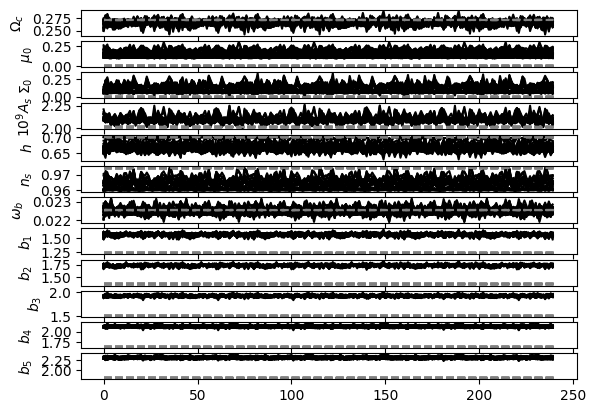

In [39]:
sampler_PCA_arr = np.reshape(raw_chain, (len(raw_chain[0]), len(raw_chain), len(raw_chain[0][0])))

fig, ax = plt.subplots(len(sampler_PCA_arr[0, 0, :]), sharex=True)
labels = [r"$\Omega_c$", r"$\mu_0$", r"$\Sigma_0$", r"$10^{9}A_s$", r"$h$", r"$n_s$", r"$\omega_b$",\
         r'$b_1$', r'$b_2$', r'$b_3$', r'$b_4$', r'$b_5$']

Bias_distribution_fiducial = np.array([1.229,
                            1.362,
                            1.502,
                            1.648,
                            1.799])

value1 = [cosmo_universe["Omega_c"], 0.0, 0.0,cosmo_universe["A_s"]*1e9, cosmo_universe["h"],\
          cosmo_universe["n_s"],cosmo_universe["Omega_b"]*cosmo_universe["h"]**2,\
         Bias_distribution_fiducial[0], Bias_distribution_fiducial[1],\
         Bias_distribution_fiducial[2],Bias_distribution_fiducial[3],\
         Bias_distribution_fiducial[4]]

for i in range(len(sampler_PCA_arr)):
    for j in range(len(sampler_PCA_arr[0, 0, :])):
        ax[j].plot(sampler_PCA_arr[i, :, j], color = "black")
        ax[j].plot([0,len(sampler_PCA_arr[0, :, 0])],[value1[j],value1[j]], color="gray", linestyle="--")
        ax[j].set_ylabel(labels[j])
        